# Fun with CCDs

**LSST-DA Data Science Fellowship Program**

*by Alex Drlica-Wagner*


This set of exercises is intended to get you familiar with some of the intricacies of working with images from CCDs. This may be the only time you touch raw LSST images (well, actually DP1 images from LSSTComCam, but close enough). The goal is to get a sense for the "warts and pimples" in the data.

## Get the Data

This section goes through how to access a raw image from the butler. You don't need to know what is going on under the hood here, just think of this as a way to access a non-local file server. **If you don't have access to the [Rubin Science Platform](https://data.lsst.cloud/), please contact the instructor!**

If at some point you are interested in more details about accessing the raw images, you can check out the associated tutorial notebook: [202.5. Raw images](https://dp1.lsst.io/tutorials/notebook/202/notebook-202-5.html)

In [37]:
# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

# The DP1 data lives in a butler collection.
config = 'dp1'
collections = "LSSTComCam/DP1"
butler = dafButler.Butler(config, collections=collections)

In [38]:
# We choose the CCD image that we want to grab.
# The LSSTComCam focal plane contains 9 CCDs
dataId = {'instrument': 'LSSTComCam', 'detector': 1, 'exposure': 2024120200065, 'band': 'g'}
#dataId = {'instrument': 'LSSTComCam', 'detector': 1, 'exposure': 2024120200066, 'band': 'g'}
print(dataId)

# Now we get the raw image, which is an ExposureF object
print("Getting raw...")
raw = butler.get('raw', dataId)
print(raw)

{'instrument': 'LSSTComCam', 'detector': 1, 'exposure': 2024120200065, 'band': 'g'}
Getting raw...


In [39]:
# We can save the image to a FITS file.
outfile = f"{dataId['instrument']}_{dataId['exposure']}_{dataId['detector']:03d}_{dataId['band']}_raw.fits"
print(outfile)
print(f"Writing {outfile}...")
raw.writeFits(outfile)

LSSTComCam_2024120200065_001_g_raw.fits
Writing LSSTComCam_2024120200065_001_g_raw.fits...


## Exercise 1. Exploring the Image

The following exercises asks you to visualize and explore the pixel information in the raw image.

### Visualize the image

**Option 1:** If you are familiar with the standard FITS image viewer tool [SAOImageDS9](https://sites.google.com/cfa.harvard.edu/saoimageds9) (commonly known as `ds9`), then probably the easiest way to view the image is to download it and view it with ds9 locally. If you don't have `ds9` on your machine, you can download it for most systems using the link above.

* Execute the cells above to save the image to a FITS file.
* Download the FITS file by right clicking on the icon associated with the file in the File Browser (to the left of this notebook) and select "Download.
* Open the FITS file with ds9. You can do this from the ds9 GUI menu with "File" -> "Open", or from the command line with:

```
ds9 LSSTComCam_2024120200065_001_g_raw.fits
```

**Option 2:** You can view the image interactively using the Firefly visualization interface. To do this, execute the following code in a cell. This should open a new notebook tab with a firefly frame and that displays the raw image.

```
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)
afw_display.image(raw.image)
```

In [40]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)
afw_display.image(raw.image)

<span style="color:blue;font-weight: bold;">Exercise:</span> How many distinct sections (amplifiers) are the LSST CCDs divided into?

<span style="color:red">16 distinct sections</span>

<span style="color:blue;font-weight: bold;">Exercise:</span> Why is it difficult to visualize all the section at a single dynamic range?

<span style="color:red">Because the CCD has a logarithmic response (?)</span>

<span style="color:blue;font-weight: bold;">Exercise:</span> What are the darker regions separating each section of the image? Are there any astronomical objects located in these regions?

<span style="color:red">They are 'virtual' pixels from overscanning, used as a baseline for the amplifier response.</span>

### Identify artifacts

The next set of questions asks you to identify examples of several different artifacts in the image. Feel free to use Google/ChatGPT to find examples of each of these artifacts.

* **Saturation**: when the amount of charge in a pixel exceeds the maximum amount that can be confined to the pixel (i.e., the "full well").
* **Bleed trail**: electrons from a super-saturated source that start to "bleed" away from that source.
* **Crosstalk**: electronic signals from a bright "agressor" in one amplifier that can be seen in pixels of "victim" amplifiers that were read out at the same time.
* **Cosmic ray**: energetic charged particle that has penetrated the CCD and left an ionization trail
* **Bad pixel(s)**: one or a small group of pixels with an abnormal response.
* **Bad column**: a defect in the CCD pixel array that can either be bright (producing excess charge) or dark (trapping charge).
* **Bias dip**: the electronic bias level can change within an image introducing apparent dips and features in the background level.

<span style="color:blue;font-weight: bold;">Exercise:</span> Make a copy of the slides you find [here](https://docs.google.com/presentation/d/1E4QCea72qiVExO_G8DiDuLRe-wKOfRL9njHUHDwMsjY). There is one per artifact. Insert a screenshot showing an example of the artifact and complete the associated questions on the slide.

<span style="color:red"> Link to your slides here...</span> [link](https://docs.google.com/presentation/d/1WPAL5149YHr2HXFG_JV51NJc6rdIVUgMxsfxCVIQ2iw/edit?usp=sharing)

## Exercise 2. Overscan Bias Correction

In this section we are going to isolate the part of the image showing pixels that were exposed to the sky and use the overscan region to correct for the major electronic effects introduced by the amplifier.

In [41]:
# Change the default plotting backend to matplotlib
import matplotlib.pyplot as plt
afwDisplay.setDefaultBackend('matplotlib')

<span style="color:blue;font-weight: bold;">Exercise:</span> Use matplotlib to plot the full raw image. Play with the `vmin` and `vmax` parameters until you can see astronomical objects in almost every section.

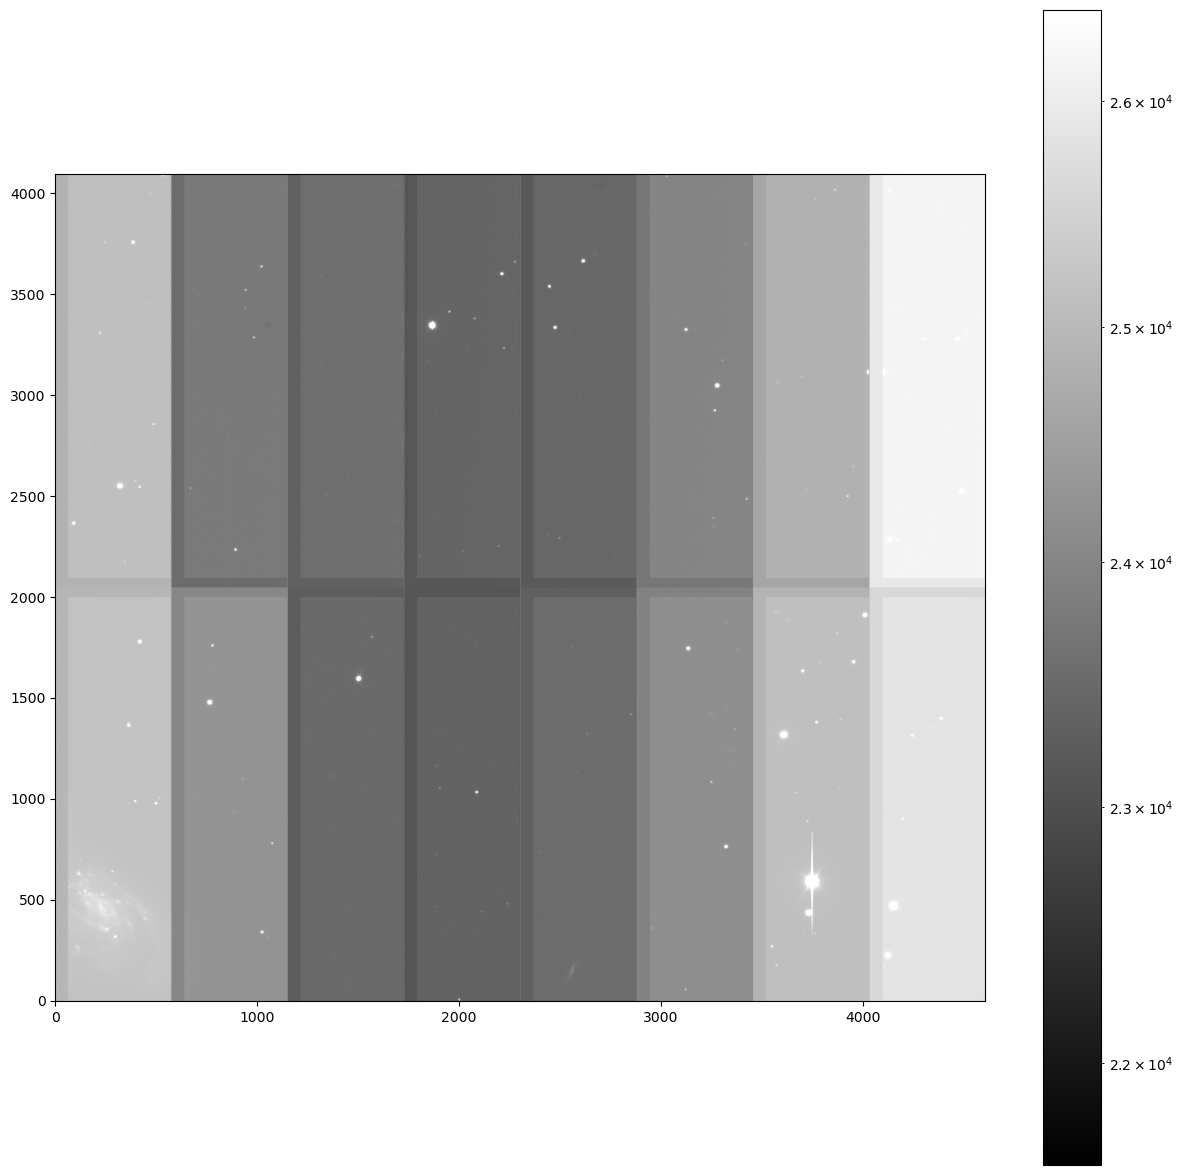

In [42]:
data = raw.image.array
# vmin, vmax = 1e4, 0.5e5
import numpy as np
vmin, vmax = np.percentile(data, [50, 50])

fig, ax = plt.subplots(figsize=(15, 15))

im = ax.imshow(
    data,
    cmap='gray',
    origin='lower',
    norm='log',
    vmin=vmin,
    vmax=vmax
)

# cbar = fig.colorbar(im, ax=ax)

Divide the image into amplifier sections. Note that in the above image, the origin (0, 0) is in the lower left corner so the bottom amplifiers have row index 0 and the top amplifiers have row index 1.

In [43]:
# Amplifier sections
amp_nrow,amp_ncol = (2,8)
ysize = data.shape[0] // amp_nrow
xsize = data.shape[1] // amp_ncol
amplifiers = dict()
for j in range(amp_nrow):
    ymin,ymax = j*ysize, j*ysize + ysize
    for i in range(amp_ncol):
        xmin,xmax = i*xsize, i*xsize + xsize
        amplifiers[f'amp{j}{i}'] = data[ymin:ymax,xmin:xmax].copy()

<span style="color:blue;font-weight: bold;">Exercise:</span> Use matplotlib to plot what we are calling "amplifier 05" (`amp05` entry in the `amplifiers` dictionary). Set the vmin/vmax values so that you can see stars and galaxies. Answer the following questions:
* Where is the serial overscan?
* Where is the vertical overscan?
* In which corner is the readout amplifier located?
* Why are the overscan region much darker than the image of the sky?

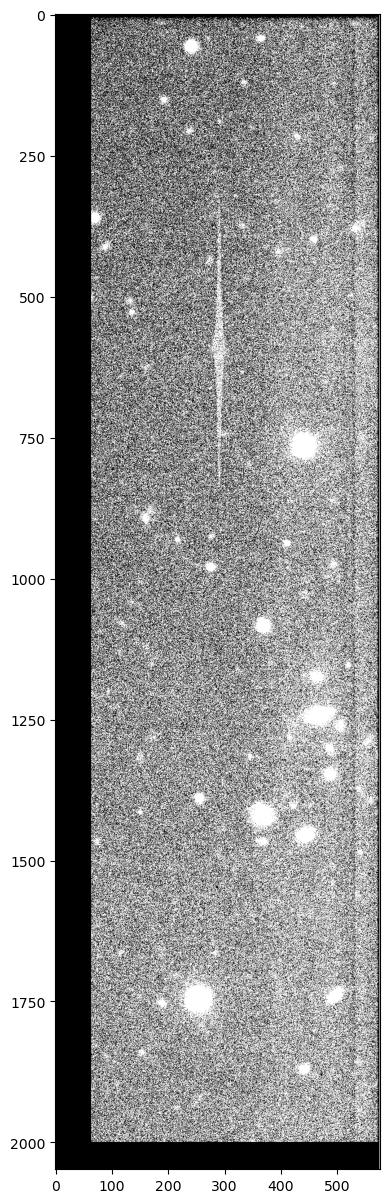

In [47]:
# Adjust vmin and vmax here.
amp = amplifiers['amp05']
# vmin,vmax = None, None
vmin,vmax = np.percentile(amp, [25,75])

fig, ax = plt.subplots(figsize=(15, 15))

im = ax.imshow(amp,norm='log',cmap='gray', vmin=vmin, vmax=vmax)

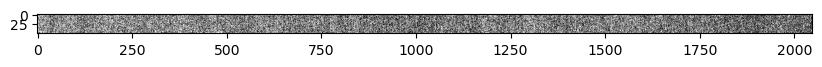

In [65]:
# Adjust vmin and vmax here.
amp = amplifiers['amp05']
# vmin,vmax = None, None
vmin,vmax = np.percentile(amp[:,0:50], [25,75])

fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(amp[:,0:50].T,norm='log',cmap='gray', vmin=vmin, vmax=vmax)

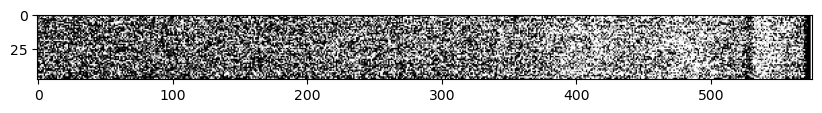

In [66]:
# Adjust vmin and vmax here.
amp = amplifiers['amp05']
# vmin,vmax = None, None
vmin,vmax = np.percentile(amp[2000:], [25,75])

fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(amp[2000:],norm='log',cmap='gray', vmin=vmin, vmax=vmax)

<span style="color:blue;font-weight: bold;">Exercise:</span> Plot just the serial overscan and just the parallel overscan regions of amplifier 05 (`amp05`). Do you see more structure in the serial or parallel overscan?

In [ ]:
# Your code here

#serial_overscan: columns 0 to 65
#parallel_overscan: rows 2000 to 2046

<span style="color:blue;font-weight: bold;">Exercise:</span> Calculate the median for each column of the parallel overscan and subtract it from each column of the science image. Does the resulting science image look better?

In [ ]:
# Your code here....

## Extra Credit: Stitch it all back together

In this exercise we will use what we learned from the previous examples to subtract the median from the parallel overscan from the science images and stitch everything back together. This can be done pretty efficiently with numpy...

* Loop over the amplifiers in row 0. For each amplifier, perform the overscan bias correction. Keep only the on-sky region of the image (i.e., clip off the overscan) and append to an output list.
* Use np.hstack to combine the amplifiers in your row 0 output list into a single array.
* Do the same procedure for row 1.
* Use np.vstack to combine the array for row 0 and row 1.
* Plot the resulting image.
* Why are there still some dark lines?

In [ ]:
# Your code here...